In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
from sklearn.metrics import classification_report
import torch

In [2]:
# Load the pre-trained model and tokenizer
model_name = "./finetuned_wikineural"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [4]:
# Load preprocessed German dataset
from datasets import load_from_disk
german_dataset = load_from_disk("Data_de/test_de")

In [2]:
print(german_dataset[0])  # Print the first example
print(german_dataset.features)  # Print the dataset features


{'tokens': ['WEITERLEITUNG', 'Hu', 'Xian'], 'ner_tags': [0, 5, 6, 6, 6], 'langs': ['de', 'de', 'de', 'de', 'de'], 'spans': ['LOC: Hu ( Xi’an )'], 'input_ids': [101, 160, 11259, 37611, 24093, 51036, 37611, 69849, 11447, 43707, 59876, 10206, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, -100, -100, -100, -100, -100, -100, -100, 5, 6, -100, -100]}
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'spans': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention

In [5]:
from collections import Counter

# extract ner_tags from dataset
ner_tags = [tag for example in german_dataset for tag in example["ner_tags"]]

# map numeric labels to entity names
tag_map = {
    0: "O",        # Outside any entity
    1: "B-PER",    # Beginning of a Person entity
    2: "I-PER",    # Inside a Person entity
    3: "B-ORG",    # Beginning of an Organization entity
    4: "I-ORG",    # Inside an Organization entity
    5: "B-LOC",    # Beginning of a Location entity
    6: "I-LOC"     # Inside a Location entity
}

ner_labels = [tag_map[tag] for tag in ner_tags]

# count entities
entity_counts = Counter(ner_labels)

In [6]:
# filter entities
filtered_counts = {
    entity: count for entity, count in entity_counts.items() 
    if entity.startswith(('B-', 'I-'))  
}

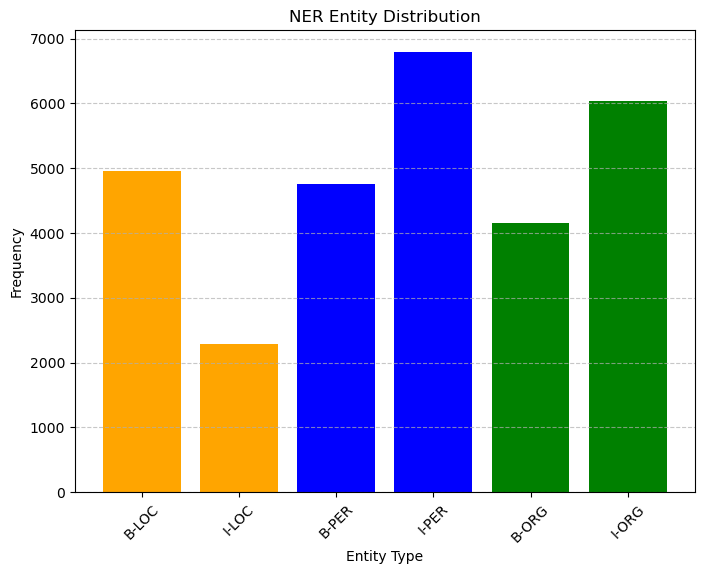

In [9]:
import matplotlib.pyplot as plt

# prepare data for diagram
entities = list(filtered_counts.keys())
counts = list(filtered_counts.values())

# define colours based in entity types
color_map = {
    "PER": "blue",
    "LOC": "orange",
    "ORG": "green"
}

# assign colours for the bars
colors = [color_map[entity.split("-")[1]] for entity in entities]

# create diagram
plt.figure(figsize=(8, 6))
plt.bar(entities, counts, color=colors)
plt.xlabel("Entity Type")
plt.ylabel("Frequency")
plt.title("NER Entity Distribution")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [6]:
def prepare_dataset(examples):
    # The tokenization step is not needed as input_ids are already present
    return {
        'input_ids': examples['input_ids'],
        'attention_mask': examples['attention_mask'],
        'token_type_ids': examples['token_type_ids'],
        'labels': examples['labels']
    }

tokenized_german = german_dataset.map(prepare_dataset, batched=True)


In [7]:
# Create a data loader:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'attention_mask': torch.tensor([item['attention_mask'] for item in batch]),
        'token_type_ids': torch.tensor([item['token_type_ids'] for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch])
    }

data_loader = DataLoader(tokenized_german, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [8]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask']) for item in batch]
    token_type_ids = [torch.tensor(item['token_type_ids']) for item in batch]
    labels = [torch.tensor(item['labels']) for item in batch]
    
    # Pad sequences to the maximum length in the batch
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    token_type_ids = pad_sequence(token_type_ids, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for padding in labels
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'labels': labels
    }

data_loader = DataLoader(tokenized_german, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [9]:
from tqdm import tqdm
from seqeval.metrics import classification_report
import torch

model.eval()
all_predictions = []
all_true_labels = []

label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}

with torch.no_grad():
    for batch in tqdm(data_loader, desc="Evaluating"):
        # check if all the keys are present
        assert 'input_ids' in batch and 'attention_mask' in batch and 'labels' in batch, \
            "Batch fehlt erforderliche Schlüssel!"

        # load inputs and labels to the right device
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(model.device)
        
        # generate predictions
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2)
        
        # process labels and predictions
        for pred, label, mask in zip(predictions, labels, batch['attention_mask']):
            pred = pred.cpu().numpy()
            label = label.cpu().numpy()
            mask = mask.cpu().numpy()

            # filter with attention_mask
            true_label = [label_map.get(l, 'O') for l, m in zip(label, mask) if m != 0]
            pred_label = [label_map.get(p, 'O') for p, m in zip(pred, mask) if m != 0]
            
            # align length of list if necessary
            if len(true_label) != len(pred_label):
                min_len = min(len(true_label), len(pred_label))
                true_label = true_label[:min_len]
                pred_label = pred_label[:min_len]
            
            all_predictions.append(pred_label)
            all_true_labels.append(true_label)

print(classification_report(all_true_labels, all_predictions))


Evaluating: 100%|██████████| 625/625 [01:34<00:00,  6.62it/s]


              precision    recall  f1-score   support

         LOC       0.25      0.30      0.27      4189
         ORG       0.22      0.21      0.22      4884
         PER       0.21      0.19      0.19      5839

   micro avg       0.22      0.23      0.22     14912
   macro avg       0.22      0.23      0.23     14912
weighted avg       0.22      0.23      0.22     14912



In [24]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import numpy as np

# load model and tokenizer
model_name = "./finetuned_wikineural"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# example
sentence = "Julia arbeitet bei Starbucks in Bern."

# tokenization
inputs = tokenizer(
    sentence,
    return_tensors="pt",  # pytorch tensor
    padding=True,
    truncation=True,
    is_split_into_words=False  # if sentence already tokenized then true
)

# inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# convert logits to predictions
logits = outputs.logits
predictions = torch.argmax(logits, dim=2).squeeze().tolist()

# convert token-ids to tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())

# map label-ids
label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}

# map tokens to labels
results = []
for token, prediction in zip(tokens, predictions):
    label = label_map[prediction]
    results.append((token, label))

# filter tokens
filtered_results = [(token, label) for token, label in results if label != 'O' and token not in tokenizer.all_special_tokens]

for token, label in filtered_results:
    print(f"Token: {token}, Label: {label}")


Token: Star, Label: B-ORG
Token: ##bu, Label: I-ORG
Token: ##cks, Label: I-ORG
Token: Bern, Label: B-LOC


In [20]:
print(tokenizer.tokenize(sentence))


['Julia', 'arbeitet', 'bei', 'Star', '##bu', '##cks', 'in', 'Bern', '.']


In [21]:
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
logits = outputs.logits
predictions = torch.argmax(logits, dim=2)

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
predicted_labels = [label_map[pred.item()] for pred in predictions.squeeze()]

# map tokens to label
for token, label in zip(tokens, predicted_labels):
    print(f"Token: {token}, Label: {label}")


Token: [CLS], Label: O
Token: Julia, Label: O
Token: arbeitet, Label: O
Token: bei, Label: O
Token: Star, Label: B-ORG
Token: ##bu, Label: I-ORG
Token: ##cks, Label: I-ORG
Token: in, Label: O
Token: Bern, Label: B-LOC
Token: ., Label: O
Token: [SEP], Label: O
